In [1]:
import os

QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10        # percentiles of predictions: lower bounds
qU1, qU2 = 1-qL1, 1-qL2,     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import missingno as mno
import pywt
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, NBEATSModel, NHiTSModel
from darts.models import AutoARIMA, LinearRegressionModel, RegressionEnsembleModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.metrics import mape, rmse, smape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
xls = pd.ExcelFile('df_radon_combined.xlsx')

df_radon = {}
for num in xls.sheet_names[2:]:
    df_radon[num] = pd.read_excel(xls, num) 

#remove these indexes
devices = ['1', '2', '5', '9', '17', '23', '27', '28', '36', '44', '48']
for key in list(df_radon):
    if key in devices:
        del df_radon[key]

for key in df_radon:
    print(key)
    df_radon[key]['SyncDate'] = pd.to_datetime(df_radon[key]['SyncDate'])
    print(f"{df_radon[key]['SyncDate'].min()} - {df_radon[key]['SyncDate'].max()}")
    df_radon[key].sort_values(by='SyncDate', ascending=True, inplace=True)
    df_radon[key]['SyncDate'] = df_radon[key]['SyncDate'].dt.floor('H')
    df_radon[key] = df_radon[key].resample('H', on = 'SyncDate').mean()
    df_radon[key] = df_radon[key].interpolate(method='linear', limit_direction='both')
    start_time = pd.to_datetime('2022-05-11T18:29:00.000000000')
    end_time = pd.to_datetime('2023-06-06T12:00:00.000000000')
    df_radon[key] = df_radon[key][(df_radon[key].index >= start_time) & (df_radon[key].index <= end_time)]
    print(f"{df_radon[key].index.min()} - {df_radon[key].index.max()}")

3
2022-05-08 00:16:30 - 2023-06-06 12:25:38
2022-05-11 19:00:00 - 2023-06-06 12:00:00
4
2022-05-08 00:17:23 - 2023-06-06 12:26:06
2022-05-11 19:00:00 - 2023-06-06 12:00:00
7
2022-04-01 10:18:57 - 2023-06-06 12:30:25
2022-05-11 19:00:00 - 2023-06-06 12:00:00
8
2022-04-04 18:52:46 - 2023-06-06 12:27:12
2022-05-11 19:00:00 - 2023-06-06 12:00:00
10
2022-05-08 00:56:00 - 2023-06-06 23:02:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
11
2022-05-08 00:50:01 - 2023-06-07 12:13:32
2022-05-11 19:00:00 - 2023-06-06 12:00:00
13
2022-05-08 00:33:33 - 2023-06-06 23:09:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
15
2022-05-08 00:39:00 - 2023-06-06 23:59:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
16
2022-05-08 00:47:00 - 2023-06-06 23:00:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
18
2022-05-08 00:49:00 - 2023-06-06 23:07:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
19
2022-05-08 00:51:00 - 2023-06-06 23:36:00
2022-05-11 19:00:00 - 2023-06-06 12:00:00
20
2022-05-08 00:54:00 - 2023-06-07 12:40:49
20

# Radon 45

In [4]:
df = df_radon['45'].copy()

In [5]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

signal = df['Radon'].copy()
wavelet_name='coif9'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [6]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [7]:
df.describe()

,AirPressure,Humidity,Radon,Temperature
count,"9,378.00","9,378.00","9,378.00","9,378.00"
mean,30.10,62.16,18.13,72.54
std,0.14,13.24,20.50,17.99
min,29.58,13.00,-0.61,15.00
25%,30.01,54.04,0.87,60.00
50%,30.10,63.00,12.20,74.00
75%,30.19,72.00,29.45,82.55
max,30.56,93.00,177.31,142.00


In [8]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [9]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-06-06 12:00:00,0.05


In [10]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.04
2023-05-30 13:00:00,0.07


In [11]:
from ray.air import session
def build_fit_linear_regression_model(
    model_args,
    callbacks=None,
    
):
#     encoders={"cyclic": {"future": ["hour"]},
#              "transformer": Scaler()
#              } if model_args['include_hour'] else None
    
    model = LinearRegressionModel(
        lags = model_args['lags'],
        output_chunk_length=model_args['output_chunk_length'],
        likelihood='quantile',
        quantiles=QUANTILES,
        multi_models=model_args['multi_models'],
        
    )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['lags']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input)
    ts_tpred = model.predict(series=ts_ttrain,
                 n=len(ts_ttest))
#     print(ts_tpred.start_time())
#     ts_tq = ts_tpred.quantile_timeseries(0.5)
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    #session.report({'q_smape':q_smape})
    #backtest result
    back_pred = model.historical_forecasts(
        series = ts_ttrain_input,
        start = len(ts_ttrain_input) - 168,
        forecast_horizon = 168)
    back_pred = scalerP.inverse_transform(back_pred)
    back_smape = smape(back_pred, ts_train)
    session.report({'q_smape':q_smape, 'back_smape':back_smape})

In [12]:
from ray.air import session
def build_fit_linear_regression_model_return(
    model_args,
    callbacks=None,
    
):
#     encoders={"cyclic": {"future": ["hour"]},
#              "transformer": Scaler()
#              } if model_args['include_hour'] else None
    
    model = LinearRegressionModel(
        lags = model_args['lags'],
        output_chunk_length=model_args['output_chunk_length'],
        likelihood='quantile',
        quantiles=QUANTILES,
        multi_models=model_args['multi_models'],
        
    )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['lags']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input)
#     ts_tpred = model.predict(series=ts_ttrain,
#                  future_covariates=covF_t,
#                  n=len(ts_ttest))
# #     print(ts_tpred.start_time())
# #     ts_tq = ts_tpred.quantile_timeseries(0.5)
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape':q_smape})
    return model

In [13]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration. import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":'validation_0-rmse'
#     }
# )

#define the hyperparameter search space
config = {
    "lags": tune.randint(8,168),
    "output_chunk_length":tune.randint(1,4),
    "multi_models":tune.choice([True, False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape", "back_smape"])
resources_per_trial = {"cpu": 2}

num_samples = 100

algo = OptunaSearch()
algo = ConcurrencyLimiter(algo, max_concurrent=20)
scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_linear_regression_model,)

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric='q_smape',
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="lr_tune",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-06 17:05:26 (running for 00:00:00.15)
Memory usage on this node: 5.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 1/100 (1 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
+------------------------------------------

(build_fit_linear_regression_model pid=41227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41227) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41227) Result message of linprog:
(build_fit_linear_regression_model pid=41227) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41227)   warnings.warn(
(build_fit_linear_regression_model pid=41845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41845) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:05:47 (running for 00:00:20.78)
Memory usage on this node: 47.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41773) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41773) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41773) Result message of linprog:
(build_fit_linear_regression_model pid=41773) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41773)   warnings.warn(
(build_fit_linear_regression_model pid=41227) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41227) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:05:52 (running for 00:00:25.79)
Memory usage on this node: 60.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41479) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41479) Result message of linprog:
(build_fit_linear_regression_model pid=41479) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41479)   warnings.warn(
(build_fit_linear_regression_model pid=41477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41477) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:05:57 (running for 00:00:30.80)
Memory usage on this node: 66.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41477) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41477) Result message of linprog:
(build_fit_linear_regression_model pid=41477) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41477)   warnings.warn(
(build_fit_linear_regression_model pid=41479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41479) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:06:02 (running for 00:00:35.81)
Memory usage on this node: 70.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41477) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41477) Result message of linprog:
(build_fit_linear_regression_model pid=41477) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41477)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:06:07 (running for 00:00:40.81)
Memory usage on this node: 68.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41774) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41774) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41774) Result message of linprog:
(build_fit_linear_regression_model pid=41774) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41774)   warnings.warn(
(build_fit_linear_regression_model pid=41469) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41469) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:06:22 (running for 00:00:55.85)
Memory usage on this node: 61.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

(build_fit_linear_regression_model pid=41473) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41473) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41473) Result message of linprog:
(build_fit_linear_regression_model pid=41473) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41473)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:06:27 (running for 00:01:00.85)
Memory usage on this node: 64.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_31b38148 | RUNNING  | 172.31.10.87:41227 |    124 |                     2 | True           |
| build_fit_linear_regression_model_47e

Trial name,back_smape,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,q_smape,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
build_fit_linear_regression_model_019984b1,48.5011,2023-07-06_17-06-43,True,,d1c2acaa1a7044b48d1612a30905f77e,"15_lags=109,multi_models=False,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,41774,12.1462,65.8753,65.8753,65.8753,1688663203,0,,1,019984b1,0.00459623
build_fit_linear_regression_model_02ff3b43,48.4018,2023-07-06_17-11-16,True,,f3bc7abc35484aee9bf72112e185e26e,"64_lags=100,multi_models=False,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,53267,12.1367,64.1769,64.1769,64.1769,1688663476,0,,1,02ff3b43,0.00339413
build_fit_linear_regression_model_030ce719,48.3216,2023-07-06_17-10-09,True,,6226006ef75a4c92afc51e3ccdb5dfd7,"48_lags=68,multi_models=False,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,50304,12.1291,62.9035,62.9035,62.9035,1688663409,0,,1,030ce719,0.00570369
build_fit_linear_regression_model_054c263e,48.4772,2023-07-06_17-11-19,True,,6226006ef75a4c92afc51e3ccdb5dfd7,"68_lags=105,multi_models=False,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,50304,12.1424,65.6027,65.6027,65.6027,1688663479,0,,1,054c263e,0.00570369
build_fit_linear_regression_model_0742540f,48.4588,2023-07-06_17-12-27,True,,6ed35b429e8a460bb32730fd5b877e74,"83_lags=104,multi_models=False,output_chunk_length=2",ip-172-31-10-87,1,172.31.10.87,57360,12.1392,59.9761,59.9761,59.9761,1688663547,0,,1,0742540f,0.00371575
build_fit_linear_regression_model_0cc6385f,48.0154,2023-07-06_17-09-03,True,,d3dfe64832594fe985d974237231ba24,"31_lags=90,multi_models=True,output_chunk_length=2",ip-172-31-10-87,1,172.31.10.87,46667,12.0834,130.265,130.265,130.265,1688663343,0,,1,0cc6385f,0.00572515
build_fit_linear_regression_model_0dc29059,48.4018,2023-07-06_17-11-23,True,,4a7dc5a967b5454f9d2b671a9d7b0d11,"70_lags=100,multi_models=False,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,54100,12.1367,63.369,63.369,63.369,1688663483,0,,1,0dc29059,0.00436425
build_fit_linear_regression_model_1230e803,48.0154,2023-07-06_17-11-20,True,,8ea90b140f914260aa00eb663b73bc24,"42_lags=77,multi_models=True,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,49158,12.0989,191.232,191.232,191.232,1688663480,0,,1,1230e803,0.00771737
build_fit_linear_regression_model_13249063,48.0015,2023-07-06_17-08-59,True,,32a10cca7b764223825c3c5ddbaa4ef9,"36_lags=80,multi_models=False,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,47899,12.0813,66.7403,66.7403,66.7403,1688663339,0,,1,13249063,0.00613689
build_fit_linear_regression_model_14bfe16a,48.6829,2023-07-06_17-06-36,True,,b2afdf01ff254702b2e8183ad2cbf4ed,"11_lags=52,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,41626,12.1716,59.0718,59.0718,59.0718,1688663196,0,,1,14bfe16a,0.00343585


== Status ==
Current time: 2023-07-06 17:06:38 (running for 00:01:11.30)
Memory usage on this node: 62.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 47e60f7a with q_smape=12.165547295402112 and parameters={'lags': 56, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 22/100 (20 RUNNING, 2 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

(build_fit_linear_regression_model pid=41471) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41471) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41471) Result message of linprog:
(build_fit_linear_regression_model pid=41471) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41471)   warnings.warn(
(build_fit_linear_regression_model pid=41528) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41528) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:06:50 (running for 00:01:23.75)
Memory usage on this node: 59.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 31/100 (20 RUNNING, 11 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=45718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=45718) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=45718) Result message of linprog:
(build_fit_linear_regression_model pid=45718) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=45718)   warnings.warn(
(build_fit_linear_regression_model pid=46194) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=46194) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:06:58 (running for 00:01:31.67)
Memory usage on this node: 54.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=45718) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=45718) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=45718) Result message of linprog:
(build_fit_linear_regression_model pid=45718) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=45718)   warnings.warn(
(build_fit_linear_regression_model pid=46184) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=46184) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:07:05 (running for 00:01:39.10)
Memory usage on this node: 66.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=46184) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=46184) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=46184) Result message of linprog:
(build_fit_linear_regression_model pid=46184) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=46184)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:07:10 (running for 00:01:44.11)
Memory usage on this node: 64.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=41479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41479) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41479) Result message of linprog:
(build_fit_linear_regression_model pid=41479) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41479)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:07:20 (running for 00:01:54.14)
Memory usage on this node: 60.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=41479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41479) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41479) Result message of linprog:
(build_fit_linear_regression_model pid=41479) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41479)   warnings.warn(
(build_fit_linear_regression_model pid=41845) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41845) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:07:25 (running for 00:01:59.15)
Memory usage on this node: 58.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=41528) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41528) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41528) Result message of linprog:
(build_fit_linear_regression_model pid=41528) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41528)   warnings.warn(
(build_fit_linear_regression_model pid=41479) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41479) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:07:30 (running for 00:02:04.16)
Memory usage on this node: 61.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 33/100 (20 RUNNING, 13 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:07:41 (running for 00:02:15.07)
Memory usage on this node: 58.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 34/100 (20 RUNNING, 14 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:07:52 (running for 00:02:26.09)
Memory usage on this node: 52.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 37/100 (20 RUNNING, 17 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:08:08 (running for 00:02:42.19)
Memory usage on this node: 62.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 43/100 (20 RUNNING, 23 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:08:21 (running for 00:02:54.24)
Memory usage on this node: 70.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 43/100 (20 RUNNING, 23 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:08:31 (running for 00:03:04.27)
Memory usage on this node: 64.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 43/100 (20 RUNNING, 23 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:08:50 (running for 00:03:23.31)
Memory usage on this node: 64.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 45/100 (20 RUNNING, 25 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:09:01 (running for 00:03:34.22)
Memory usage on this node: 56.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 38.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 48/100 (19 RUNNING, 29 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:09:16 (running for 00:03:49.82)
Memory usage on this node: 56.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 58/100 (20 RUNNING, 38 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:09:30 (running for 00:04:04.02)
Memory usage on this node: 62.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 59/100 (20 RUNNING, 39 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=49840) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=49840) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=49840) Result message of linprog:
(build_fit_linear_regression_model pid=49840) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=49840)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:09:35 (running for 00:04:09.03)
Memory usage on this node: 57.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 59/100 (20 RUNNING, 39 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=50068) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=50068) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=50068) Result message of linprog:
(build_fit_linear_regression_model pid=50068) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=50068)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:09:40 (running for 00:04:14.05)
Memory usage on this node: 60.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 59/100 (20 RUNNING, 39 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=41477) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41477) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=41477) Result message of linprog:
(build_fit_linear_regression_model pid=41477) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=41477)   warnings.warn(
(build_fit_linear_regression_model pid=41475) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=41475) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:09:45 (running for 00:04:19.06)
Memory usage on this node: 63.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 59/100 (20 RUNNING, 39 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=46667) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=46667) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=46667) Result message of linprog:
(build_fit_linear_regression_model pid=46667) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=46667)   warnings.warn(
(build_fit_linear_regression_model pid=50304) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=50304) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:09:53 (running for 00:04:27.03)
Memory usage on this node: 59.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 61/100 (20 RUNNING, 41 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=50538) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=50538) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=50538) Result message of linprog:
(build_fit_linear_regression_model pid=50538) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=50538)   warnings.warn(
(build_fit_linear_regression_model pid=51478) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=51478) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:10:02 (running for 00:04:35.68)
Memory usage on this node: 58.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 62/100 (20 RUNNING, 42 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=52338) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=52338) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=52338) Result message of linprog:
(build_fit_linear_regression_model pid=52338) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=52338)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:10:09 (running for 00:04:43.00)
Memory usage on this node: 50.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 65/100 (20 RUNNING, 45 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=53264) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=53264) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=53264) Result message of linprog:
(build_fit_linear_regression_model pid=53264) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=53264)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:10:16 (running for 00:04:49.30)
Memory usage on this node: 48.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 71/100 (20 RUNNING, 51 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=53267) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=53267) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=53267) Result message of linprog:
(build_fit_linear_regression_model pid=53267) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=53267)   warnings.warn(
(build_fit_linear_regression_model pid=53577) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=53577) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:10:21 (running for 00:04:54.75)
Memory usage on this node: 46.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 76/100 (20 RUNNING, 56 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=54293) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=54293) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=54293) Result message of linprog:
(build_fit_linear_regression_model pid=54293) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=54293)   warnings.warn(
(build_fit_linear_regression_model pid=53941) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=53941) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:10:32 (running for 00:05:05.36)
Memory usage on this node: 61.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 78/100 (20 RUNNING, 58 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=55083) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=55083) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=55083) Result message of linprog:
(build_fit_linear_regression_model pid=55083) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=55083)   warnings.warn(
(build_fit_linear_regression_model pid=55183) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=55183) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:10:39 (running for 00:05:13.09)
Memory usage on this node: 69.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 78/100 (20 RUNNING, 58 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=53033) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=53033) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=53033) Result message of linprog:
(build_fit_linear_regression_model pid=53033) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=53033)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:10:44 (running for 00:05:18.10)
Memory usage on this node: 72.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 78/100 (20 RUNNING, 58 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=55985) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=55985) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=55985) Result message of linprog:
(build_fit_linear_regression_model pid=55985) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=55985)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:10:49 (running for 00:05:23.12)
Memory usage on this node: 65.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 78/100 (20 RUNNING, 58 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=50304) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=50304) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=50304) Result message of linprog:
(build_fit_linear_regression_model pid=50304) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=50304)   warnings.warn(
(build_fit_linear_regression_model pid=54048) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=54048) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:10:55 (running for 00:05:29.08)
Memory usage on this node: 57.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 79/100 (20 RUNNING, 59 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=56448) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=56448) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=56448) Result message of linprog:
(build_fit_linear_regression_model pid=56448) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=56448)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:11:09 (running for 00:05:42.85)
Memory usage on this node: 62.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 81/100 (20 RUNNING, 61 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=56834) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=56834) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=56834) Result message of linprog:
(build_fit_linear_regression_model pid=56834) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=56834)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:11:22 (running for 00:05:55.23)
Memory usage on this node: 47.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 86/100 (20 RUNNING, 66 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

(build_fit_linear_regression_model pid=57130) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=57130) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=57130) Result message of linprog:
(build_fit_linear_regression_model pid=57130) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=57130)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:11:33 (running for 00:06:06.71)
Memory usage on this node: 46.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 95/100 (20 RUNNING, 75 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:11:45 (running for 00:06:19.17)
Memory usage on this node: 63.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 98/100 (20 RUNNING, 78 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:11:58 (running for 00:06:31.32)
Memory usage on this node: 67.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 98/100 (20 RUNNING, 78 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:12:08 (running for 00:06:41.35)
Memory usage on this node: 57.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 98/100 (20 RUNNING, 78 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+------

== Status ==
Current time: 2023-07-06 17:12:20 (running for 00:06:53.83)
Memory usage on this node: 58.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 38.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9c705f01 with q_smape=12.079596791644652 and parameters={'lags': 85, 'output_chunk_length': 3, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (19 RUNNING, 81 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:12:33 (running for 00:07:06.56)
Memory usage on this node: 33.2/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 22.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cdd0bce8 with q_smape=12.079112683448233 and parameters={'lags': 84, 'output_chunk_length': 2, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (11 RUNNING, 89 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:12:47 (running for 00:07:20.39)
Memory usage on this node: 10.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 6.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cdd0bce8 with q_smape=12.079112683448233 and parameters={'lags': 84, 'output_chunk_length': 2, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (3 RUNNING, 97 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:12:57 (running for 00:07:30.44)
Memory usage on this node: 11.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cdd0bce8 with q_smape=12.079112683448233 and parameters={'lags': 84, 'output_chunk_length': 2, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:13:09 (running for 00:07:42.57)
Memory usage on this node: 8.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: cdd0bce8 with q_smape=12.079112683448233 and parameters={'lags': 84, 'output_chunk_length': 2, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (1 RUNNING, 99 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+--------

Best hyperparameters found were:  {'lags': 84, 'output_chunk_length': 2, 'multi_models': False}


In [14]:
best_model = build_fit_linear_regression_model_return(analysis.best_config)

In [15]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

In [16]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 12.079112683448233


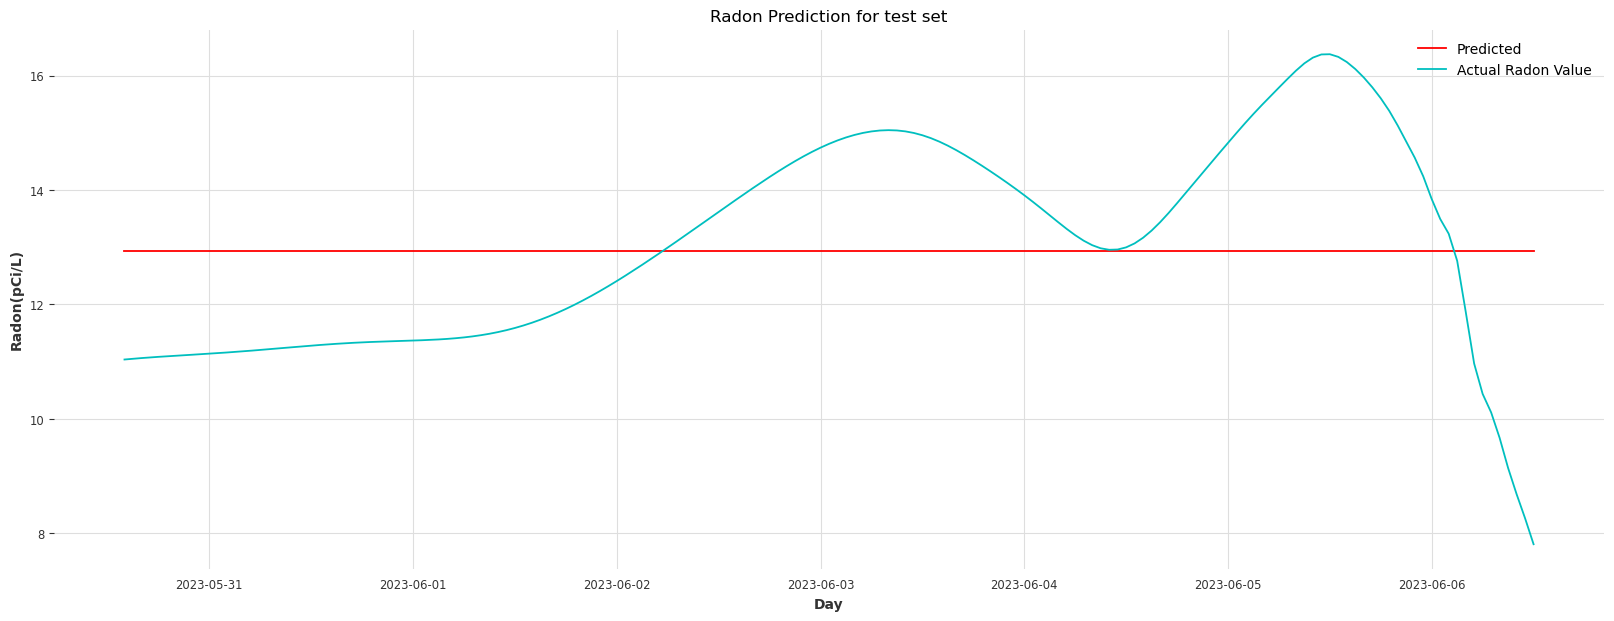

In [17]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()

# Radon 13

In [32]:
df = df_radon['13'].copy()

In [33]:
# Denoising the Radon signal
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='db4', level=5):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    n = len(x) 
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    if len(x) % 2 ==0:
        return pywt.waverec(coeff, wavelet, mode='per')
    else:
        return pywt.waverec(coeff, wavelet, mode='per')[:n]

signal = df['Radon'].copy()
wavelet_name='coif17'
filtered = wavelet_denoising(signal, wavelet=wavelet_name, level=4)
df['Radon'] = filtered

In [34]:
# any missing values?
def gaps(df):
    if df.isnull().values.any():
        print("MISSING values:\n")
        mno.matrix(df)
    else:
        print("no missing values\n")
gaps(df)

no missing values



In [35]:
df.describe()

,AirPressure,Humidity,Radon,Temperature
count,"9,378.00","9,378.00","9,378.00","9,378.00"
mean,30.09,82.47,8.82,66.32
std,0.14,14.90,12.57,16.32
min,29.52,23.00,-1.07,16.00
25%,30.00,75.00,1.17,54.00
50%,30.09,88.00,4.48,67.00
75%,30.18,94.00,12.88,76.52
max,30.62,100.00,133.74,137.00


In [36]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df["Radon"], fill_missing_dates=True, freq="H") 

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['Radon'], dtype='object', name='component')
duration: 390 days 17:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [37]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(split_point=9210)

print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled Radon time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2022-05-11 19:00:00
training end: 2023-05-30 13:00:00
training duration: 383 days 18:00:00
test start: 2023-05-30 14:00:00
test end: 2023-06-06 12:00:00
test duration: 6 days 22:00:00
first and last row of scaled Radon time series:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-06-06 12:00:00,0.05


In [38]:
print("first and last row of scaled target variable in training set: price:")
ts_ttrain.pd_dataframe().iloc[[0,-1]]

first and last row of scaled target variable in training set: price:


component,Radon
SyncDate,
2022-05-11 19:00:00,0.05
2023-05-30 13:00:00,0.02


In [39]:
from ray.air import session
def build_fit_linear_regression_model(
    model_args,
    callbacks=None,
    
):
#     encoders={"cyclic": {"future": ["hour"]},
#              "transformer": Scaler()
#              } if model_args['include_hour'] else None
    
    model = LinearRegressionModel(
        lags = model_args['lags'],
        output_chunk_length=model_args['output_chunk_length'],
        likelihood='quantile',
        quantiles=QUANTILES,
        multi_models=model_args['multi_models'],
        
    )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['lags']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input)
    ts_tpred = model.predict(series=ts_ttrain,
                 n=len(ts_ttest))
#     print(ts_tpred.start_time())
#     ts_tq = ts_tpred.quantile_timeseries(0.5)
    ts_q = scalerP.inverse_transform(ts_tpred)
    q_smape = smape(ts_q, ts_test)
    #session.report({'q_smape':q_smape})
    #backtest result
    back_pred = model.historical_forecasts(
        series = ts_ttrain_input,
        start = len(ts_ttrain_input) - 168,
        forecast_horizon = 168)
    back_pred = scalerP.inverse_transform(back_pred)
    back_smape = smape(back_pred, ts_train)
    session.report({'q_smape':q_smape, 'back_smape':back_smape})

In [40]:
from ray.air import session
def build_fit_linear_regression_model_return(
    model_args,
    callbacks=None,
    
):
#     encoders={"cyclic": {"future": ["hour"]},
#              "transformer": Scaler()
#              } if model_args['include_hour'] else None
    
    model = LinearRegressionModel(
        lags = model_args['lags'],
        output_chunk_length=model_args['output_chunk_length'],
        likelihood='quantile',
        quantiles=QUANTILES,
        multi_models=model_args['multi_models'],
        
    )
    val_len = len(ts_test)
    val_series = ts_ttrain[-((val_len) + model_args['lags']) :]
    ts_ttrain_input = ts_ttrain[:-(val_len )]
    model.fit(  ts_ttrain_input)
#     ts_tpred = model.predict(series=ts_ttrain,
#                  future_covariates=covF_t,
#                  n=len(ts_ttest))
# #     print(ts_tpred.start_time())
# #     ts_tq = ts_tpred.quantile_timeseries(0.5)
#     ts_q = scalerP.inverse_transform(ts_tpred)
#     q_smape = smape(ts_q, ts_test)
#     session.report({'q_smape':q_smape})
    return model

In [41]:
from ray import tune
from ray.tune import CLIReporter
# from ray.tune.integration. import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler, AsyncHyperBandScheduler
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search import ConcurrencyLimiter
# tune_callback = TuneReportCallback(
#     {
#         "loss":'validation_0-rmse'
#     }
# )

#define the hyperparameter search space
config = {
    "lags": tune.randint(8,168),
    "output_chunk_length":tune.randint(1,4),
    "multi_models":tune.choice([True, False]),
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["q_smape", "back_smape"])
resources_per_trial = {"cpu": 2}

num_samples = 100

algo = OptunaSearch()
algo = ConcurrencyLimiter(algo, max_concurrent=20)
scheduler = AsyncHyperBandScheduler(max_t=100, grace_period=10, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(build_fit_linear_regression_model,)

analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    metric='q_smape',
    mode="min",
    config=config,
    num_samples=num_samples,
    search_alg=algo,
    scheduler = scheduler,
    progress_reporter=reporter,
    name="lr_tune",

)

print("Best hyperparameters found were: ", analysis.best_config)

== Status ==
Current time: 2023-07-06 17:31:16 (running for 00:00:00.15)
Memory usage on this node: 4.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 1/100 (1 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_a1aef4b8 | RUNNING  | 172.31.10.87:85279 |    145 |                     2 | False          |
+------------------------------------------

== Status ==
Current time: 2023-07-06 17:31:42 (running for 00:00:25.76)
Memory usage on this node: 58.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_a1aef4b8 | RUNNING  | 172.31.10.87:85279 |    145 |                     2 | False          |
| build_fit_linear_regression_model_10e

== Status ==
Current time: 2023-07-06 17:31:57 (running for 00:00:40.79)
Memory usage on this node: 65.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_a1aef4b8 | RUNNING  | 172.31.10.87:85279 |    145 |                     2 | False          |
| build_fit_linear_regression_model_10e

== Status ==
Current time: 2023-07-06 17:32:12 (running for 00:00:55.82)
Memory usage on this node: 63.3/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 20/100 (20 RUNNING)
+--------------------------------------------+----------+--------------------+--------+-----------------------+----------------+
| Trial name                                 | status   | loc                |   lags |   output_chunk_length | multi_models   |
|--------------------------------------------+----------+--------------------+--------+-----------------------+----------------|
| build_fit_linear_regression_model_a1aef4b8 | RUNNING  | 172.31.10.87:85279 |    145 |                     2 | False          |
| build_fit_linear_regression_model_10e

Trial name,back_smape,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,q_smape,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
build_fit_linear_regression_model_007f10fe,7.1585,2023-07-06_17-36-52,True,,0e524bf368394e05aed21aa6a43e98ec,"69_lags=152,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,97317,56.7598,64.7038,64.7038,64.7038,1688665012,0,,1,007f10fe,0.00623631
build_fit_linear_regression_model_0099872b,7.34317,2023-07-06_17-33-41,True,,25ea609bec40484cb77041a0d7fa4aac,"21_lags=149,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,89736,56.7417,69.3633,69.3633,69.3633,1688664821,0,,1,0099872b,0.00635982
build_fit_linear_regression_model_02570894,9.58311,2023-07-06_17-35-39,True,,2c17568023c84b98a9a82f124a728a7b,"51_lags=120,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,94540,56.6381,61.6093,61.6093,61.6093,1688664939,0,,1,02570894,0.00525594
build_fit_linear_regression_model_026df984,9.58311,2023-07-06_17-35-52,True,,8d16498f17c340f0b6e530cac0054ebb,"53_lags=120,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,91802,56.6381,66.7068,66.7068,66.7068,1688664952,0,,1,026df984,0.00852656
build_fit_linear_regression_model_07f2d21d,9.83982,2023-07-06_17-36-12,True,,b75a5540c71f4f5b89f9fdd9814ad985,"63_lags=95,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,93176,56.72,65.1714,65.1714,65.1714,1688664972,0,,1,07f2d21d,0.00479984
build_fit_linear_regression_model_08428580,9.98192,2023-07-06_17-36-56,True,,8d16498f17c340f0b6e530cac0054ebb,"71_lags=98,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,91802,56.7164,59.8424,59.8424,59.8424,1688665016,0,,1,08428580,0.00852656
build_fit_linear_regression_model_0a4e93a6,7.82042,2023-07-06_17-33-43,True,,5bdd6f1e3aae45dfa0c5ee446fcee4cf,"18_lags=140,multi_models=True,output_chunk_length=2",ip-172-31-10-87,1,172.31.10.87,86192,56.717,136.175,136.175,136.175,1688664823,0,,1,0a4e93a6,0.0113695
build_fit_linear_regression_model_0ab7a51a,8.72409,2023-07-06_17-34-37,True,,cd936e77c3d241d991c156fcc834573b,"3_lags=72,multi_models=True,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,85504,56.8645,190.186,190.186,190.186,1688664877,0,,1,0ab7a51a,0.00389314
build_fit_linear_regression_model_0e60bfb0,10.225,2023-07-06_17-37-30,True,,694ad41eeb88469bb35efd82e281f91e,"86_lags=109,multi_models=True,output_chunk_length=1",ip-172-31-10-87,1,172.31.10.87,95808,56.6882,63.8064,63.8064,63.8064,1688665050,0,,1,0e60bfb0,0.00479388
build_fit_linear_regression_model_10eb2413,6.99676,2023-07-06_17-34-29,True,,fe305c64e037474db1038fb12384aad7,"2_lags=36,multi_models=True,output_chunk_length=3",ip-172-31-10-87,1,172.31.10.87,85502,57.5845,182.457,182.457,182.457,1688664869,0,,1,10eb2413,0.00371909


== Status ==
Current time: 2023-07-06 17:32:28 (running for 00:01:11.46)
Memory usage on this node: 56.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: 9d6701b0 with q_smape=57.16319811412377 and parameters={'lags': 54, 'output_chunk_length': 2, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 21/100 (20 RUNNING, 1 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+--------

(build_fit_linear_regression_model pid=85508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=85508) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=85508) Result message of linprog:
(build_fit_linear_regression_model pid=85508) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=85508)   warnings.warn(
(build_fit_linear_regression_model pid=85508) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=85508) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:32:39 (running for 00:01:22.50)
Memory usage on this node: 45.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 38.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 29/100 (19 RUNNING, 10 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:32:50 (running for 00:01:33.88)
Memory usage on this node: 56.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 34/100 (20 RUNNING, 14 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:33:02 (running for 00:01:45.68)
Memory usage on this node: 68.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 34/100 (20 RUNNING, 14 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:33:12 (running for 00:01:55.71)
Memory usage on this node: 67.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 34/100 (20 RUNNING, 14 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

(build_fit_linear_regression_model pid=85661) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=85661) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=85661) Result message of linprog:
(build_fit_linear_regression_model pid=85661) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=85661)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:33:17 (running for 00:02:00.73)
Memory usage on this node: 68.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 34/100 (20 RUNNING, 14 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

(build_fit_linear_regression_model pid=89977) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=89977) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=89977) Result message of linprog:
(build_fit_linear_regression_model pid=89977) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=89977)   warnings.warn(
(build_fit_linear_regression_model pid=85504) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=85504) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:33:26 (running for 00:02:09.53)
Memory usage on this node: 67.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 35/100 (20 RUNNING, 15 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

(build_fit_linear_regression_model pid=85504) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=85504) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=85504) Result message of linprog:
(build_fit_linear_regression_model pid=85504) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=85504)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:33:36 (running for 00:02:19.26)
Memory usage on this node: 64.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 36/100 (20 RUNNING, 16 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

== Status ==
Current time: 2023-07-06 17:33:50 (running for 00:02:33.51)
Memory usage on this node: 55.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: a21870c0 with q_smape=56.686685798249805 and parameters={'lags': 113, 'output_chunk_length': 1, 'multi_models': False}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 42/100 (20 RUNNING, 22 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-----

(build_fit_linear_regression_model pid=92032) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=92032) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=92032) Result message of linprog:
(build_fit_linear_regression_model pid=92032) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=92032)   warnings.warn(


== Status ==
Current time: 2023-07-06 17:33:55 (running for 00:02:38.58)
Memory usage on this node: 57.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 46/100 (20 RUNNING, 26 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:34:12 (running for 00:02:55.72)
Memory usage on this node: 65.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 50/100 (20 RUNNING, 30 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:34:22 (running for 00:03:05.76)
Memory usage on this node: 62.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 50/100 (20 RUNNING, 30 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:34:34 (running for 00:03:17.77)
Memory usage on this node: 61.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 51/100 (20 RUNNING, 31 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:34:45 (running for 00:03:29.11)
Memory usage on this node: 61.0/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 52/100 (20 RUNNING, 32 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:34:56 (running for 00:03:39.83)
Memory usage on this node: 65.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 56/100 (20 RUNNING, 36 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:35:07 (running for 00:03:50.47)
Memory usage on this node: 41.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 38.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 57/100 (19 RUNNING, 38 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:35:21 (running for 00:04:04.61)
Memory usage on this node: 51.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 68/100 (20 RUNNING, 48 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:35:33 (running for 00:04:16.45)
Memory usage on this node: 65.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 68/100 (20 RUNNING, 48 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:35:44 (running for 00:04:28.11)
Memory usage on this node: 63.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 69/100 (20 RUNNING, 49 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:35:59 (running for 00:04:42.34)
Memory usage on this node: 51.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 74/100 (20 RUNNING, 54 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:36:15 (running for 00:04:58.57)
Memory usage on this node: 51.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 78/100 (20 RUNNING, 58 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:36:31 (running for 00:05:15.15)
Memory usage on this node: 61.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 88/100 (20 RUNNING, 68 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:36:43 (running for 00:05:27.23)
Memory usage on this node: 64.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 88/100 (20 RUNNING, 68 TERMINATED)
+--------------------------------------------+------------+--------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+--------------------+-------

== Status ==
Current time: 2023-07-06 17:36:56 (running for 00:05:39.93)
Memory usage on this node: 53.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 89/100 (20 RUNNING, 69 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

(build_fit_linear_regression_model pid=99657) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=99657) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=99657) Result message of linprog:
(build_fit_linear_regression_model pid=99657) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=99657)   warnings.warn(
(build_fit_linear_regression_model pid=99762) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=99762) Status is 4: Numerical difficulties encountered.
(build_fit_linear_re

== Status ==
Current time: 2023-07-06 17:37:12 (running for 00:05:55.44)
Memory usage on this node: 60.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 94/100 (20 RUNNING, 74 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:37:27 (running for 00:06:11.22)
Memory usage on this node: 66.1/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 96/100 (20 RUNNING, 76 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:37:42 (running for 00:06:25.82)
Memory usage on this node: 62.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 99/100 (20 RUNNING, 79 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

(build_fit_linear_regression_model pid=95229) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=95229) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=95229) Result message of linprog:
(build_fit_linear_regression_model pid=95229) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=95229)   warnings.warn(
(build_fit_linear_regression_model pid=101199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=101199) Status is 4: Numerical difficulties encountered.
(build_fit_linear_

== Status ==
Current time: 2023-07-06 17:37:50 (running for 00:06:33.37)
Memory usage on this node: 61.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 99/100 (20 RUNNING, 79 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

(build_fit_linear_regression_model pid=95229) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=95229) Status is 4: Numerical difficulties encountered.
(build_fit_linear_regression_model pid=95229) Result message of linprog:
(build_fit_linear_regression_model pid=95229) An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
(build_fit_linear_regression_model pid=95229)   warnings.warn(
(build_fit_linear_regression_model pid=101199) /home/ubuntu/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
(build_fit_linear_regression_model pid=101199) Status is 4: Numerical difficulties encountered.
(build_fit_linear_

== Status ==
Current time: 2023-07-06 17:37:55 (running for 00:06:38.41)
Memory usage on this node: 67.7/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 99/100 (20 RUNNING, 79 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:38:05 (running for 00:06:48.46)
Memory usage on this node: 62.8/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 99/100 (20 RUNNING, 79 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:38:15 (running for 00:06:58.51)
Memory usage on this node: 64.6/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 99/100 (20 RUNNING, 79 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:38:28 (running for 00:07:11.82)
Memory usage on this node: 55.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 40.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (20 RUNNING, 80 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+---

== Status ==
Current time: 2023-07-06 17:38:45 (running for 00:07:29.06)
Memory usage on this node: 50.5/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 32.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (16 RUNNING, 84 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+---

== Status ==
Current time: 2023-07-06 17:38:58 (running for 00:07:42.19)
Memory usage on this node: 34.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 20.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (10 RUNNING, 90 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+---

== Status ==
Current time: 2023-07-06 17:39:11 (running for 00:07:54.95)
Memory usage on this node: 23.4/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 14.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (7 RUNNING, 93 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+----

== Status ==
Current time: 2023-07-06 17:39:24 (running for 00:08:07.49)
Memory usage on this node: 9.9/186.7 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/48 CPUs, 0/4 GPUs, 0.0/120.43 GiB heap, 0.0/55.61 GiB objects (0.0/1.0 accelerator_type:A10G)
Current best trial: c35e933a with q_smape=56.63814559967674 and parameters={'lags': 120, 'output_chunk_length': 1, 'multi_models': True}
Result logdir: /home/ubuntu/ray_results/lr_tune
Number of trials: 100/100 (2 RUNNING, 98 TERMINATED)
+--------------------------------------------+------------+---------------------+--------+-----------------------+----------------+-----------+--------------+
| Trial name                                 | status     | loc                 |   lags |   output_chunk_length | multi_models   |   q_smape |   back_smape |
|--------------------------------------------+------------+---------------------+------

Best hyperparameters found were:  {'lags': 120, 'output_chunk_length': 1, 'multi_models': True}


In [42]:
best_model = build_fit_linear_regression_model_return(analysis.best_config)

In [43]:
ts_tpred = best_model.predict(
                series = ts_ttrain,
                n = len(ts_ttest),
                verbose=True
    )

In [44]:
dfY = pd.DataFrame()
dfY['Actual'] = TimeSeries.pd_series(ts_test)
def pred(ts_tpred, ts_test):
    ts_tpred = scalerP.inverse_transform(ts_tpred)
    s = TimeSeries.pd_series(ts_tpred)
    header = "Predicted"
    dfY[header] = s
    q_smape = smape(ts_tpred, ts_test)
    print('SMAPE:',q_smape)
pred(ts_tpred, ts_test)

SMAPE: 56.63814559967674


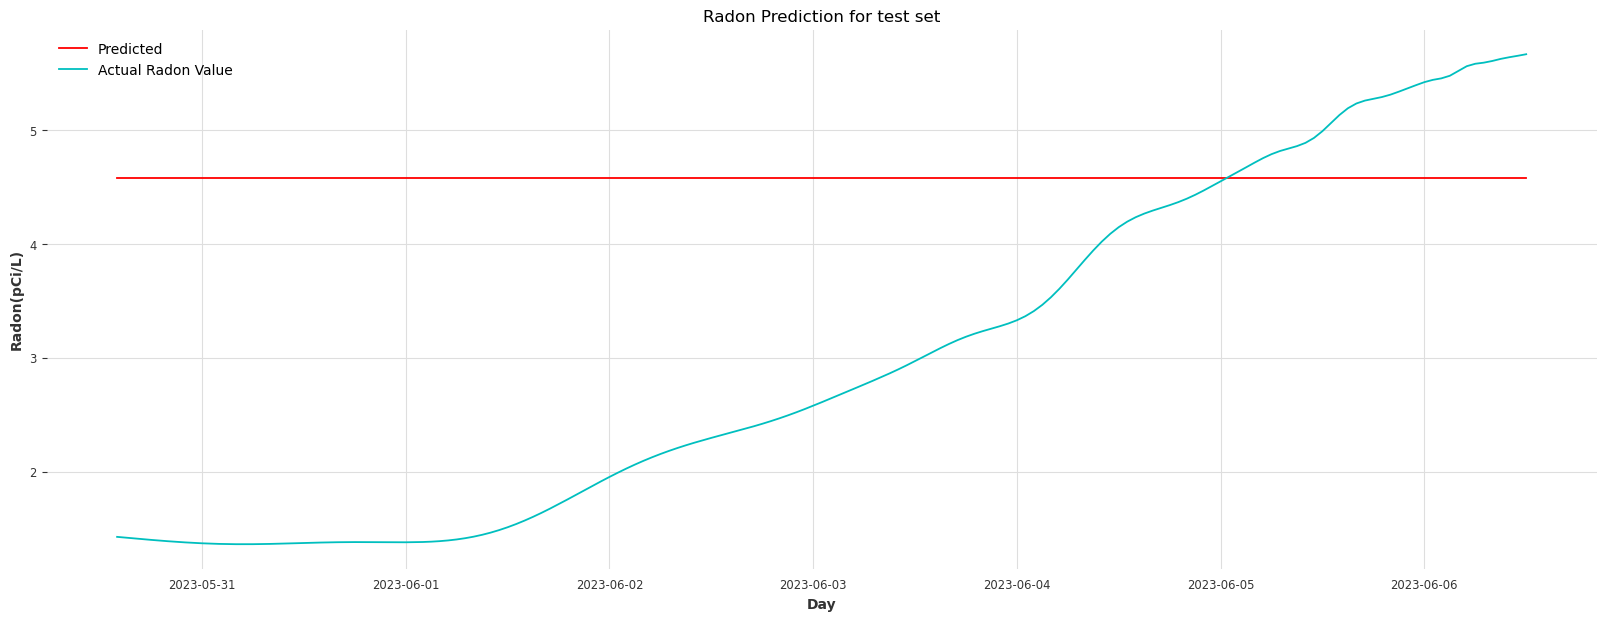

In [45]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
plt.plot(dfY.index, dfY['Predicted'], color='r', label='Predicted')
plt.plot(dfY.index, dfY['Actual'], color='c', label='Actual Radon Value')
plt.legend()
plt.title('Radon Prediction for test set')
plt.xlabel('Day')
plt.ylabel('Radon(pCi/L)')
plt.show()